In [1]:
from david_sentiment import SentimentConfig
from david_sentiment import SentimentModel
from david_sentiment.dataset import YTComments
from david_sentiment.dataset import build_dataset

Using TensorFlow backend.


### preprocessing

> Pre-processing steps before transformation; `(filtering, normalization, and sentence-tokenization)`

In [2]:
config = SentimentConfig(min_strlen=20, max_strlen=1000)
sentiment = SentimentModel(config)

# the dataset is returned as a generator.
dataset = YTComments.load_dataset_as_doc()
trainable, untrainable = build_dataset(dataset, config, untrainable=True)

sequences:   2%|▏         | 1335/61478 [00:00<00:04, 13346.89/s]

⚠  normalizing 61478 string sequences from batch.


sequences: 100%|██████████| 61478/61478 [00:54<00:00, 1130.32/s]


✔  removed 594 strings of length >= 1000.
ℹ  returning batch with 60884 samples.


sequences: 0 [00:00, ?/s]

⚠  tokenizing strings to sentences, spaCy model: en_core_web_sm.


sequences: 60884 [04:11, 241.86/s]


✔  removed 51264 strings of length <= 20.
ℹ  previous-size: 60884, new-size: 142342.
⚠  TextBlob annotating dataset with binary classes: 0 | 1
✔  annotation summary 🤖
ℹ  trainable: 73356, un-trainable: 68986


### transformation

> Tranforming the preprocessed `trainable` dataset to the format models expect.

In [3]:
x_train, y_train, x_test, y_test = sentiment.transform(trainable, mincount=2)
len(x_train), len(x_test) # 1:1 class labels for both training and test sets.

ℹ * Removed 13802 tokens from 26948


(37744, 9436)

## pre-trained model

> Training the model on GloVe embeddings

In [4]:
# build the embedding layer for the model with 300 dimensions
embedding_layer = sentiment.embedding(l2=1e-6, ndim="300d")

✔ <✔(dim=300, vocab=13147)>
✔ *** embedding vocabulary 👻 ***
✔ Glove embeddings loaded from path:
/home/ego/david_models/glove/glove.6B/glove.6B.300d.txt


In [5]:
pt_model = sentiment.compile_network(None, embedding_layer, task='pre-trained')
pt_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 125, 300)          3944100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 37500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1200032   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,144,165
Trainable params: 1,200,065
Non-trainable params: 3,944,100
_________________________________________________________________


In [6]:
history = pt_model.fit(x_train, y_train,
                       epochs=13,
                       batch_size=512,
                       validation_data=(x_test, y_test))

Train on 37744 samples, validate on 9436 samples
Epoch 1/13
37744/37744 [==============================] - 9s 249us/step - loss: 0.6003 - acc: 0.6701 - val_loss: 0.5387 - val_acc: 0.7174
Epoch 2/13
37744/37744 [==============================] - 9s 241us/step - loss: 0.4914 - acc: 0.7583 - val_loss: 0.5187 - val_acc: 0.7364
Epoch 3/13
37744/37744 [==============================] - 9s 233us/step - loss: 0.4403 - acc: 0.7911 - val_loss: 0.4996 - val_acc: 0.7532
Epoch 4/13
37744/37744 [==============================] - 9s 237us/step - loss: 0.3998 - acc: 0.8147 - val_loss: 0.4957 - val_acc: 0.7624
Epoch 5/13
37744/37744 [==============================] - 9s 237us/step - loss: 0.3665 - acc: 0.8331 - val_loss: 0.5084 - val_acc: 0.7576
Epoch 6/13
37744/37744 [==============================] - 9s 229us/step - loss: 0.3330 - acc: 0.8548 - val_loss: 0.5152 - val_acc: 0.7605
Epoch 7/13
37744/37744 [==============================] - 9s 232us/step - loss: 0.2984 - acc: 0.8746 - val_loss: 0.5625 - v

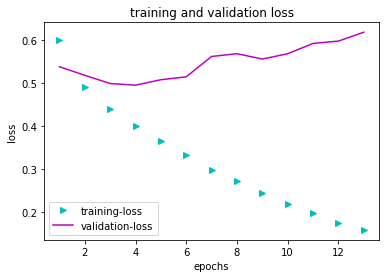

In [7]:
from david_sentiment.utils import plot_losses
plot_losses(history)

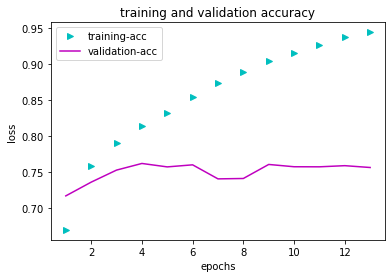

In [8]:
from david_sentiment.utils import plot_accuracy
plot_accuracy(history)

In [9]:
dev_0 = SentimentModel.clone(sentiment, pt_model)
dev_0

<SentimentModel(max_seqlen=125, vocab_size=(13147, 300))>

In [10]:
from david_sentiment.utils import test_simple, test_untrained

dev_0.predict_print("I wonder if this is a positive text?? hmm..")
dev_0.predict_print("I wonder if this is a negative text?? hmm..") # fixed logic

input: "I wonder if this is a positive text?? hmm.." < neg(😒) (46.1054)% >
input: "I wonder if this is a negative text?? hmm.." < neg(🤬) (0.3817)% >


In [38]:
test_simple(dev_0, 2)

* -- sentiment with punctuation -- *

input: "I hate this, but love it :)" < neg(🤬) (2.1428)% >
input: "I love this, but hate it :)" < pos(😁) (80.8746)% >
input: "I hate this, but love it :(" < neg(🤬) (0.1184)% >
input: "I love this, but hate it :(" < neg(😡) (9.7224)% >

* -- sentiment without punctuation -- *

input: "I hate this but love it :)" < neg(🤬) (0.7959)% >
input: "I love this but hate it :)" < neg(😳) (32.3494)% >
input: "I hate this but love it :(" < neg(🤬) (0.0492)% >
input: "I love this but hate it :(" < neg(🤬) (2.6154)% >


In [58]:
test_untrained(dev_0, untrainable, k=5)

💬 <old=0.0, new=15.545, label=0>
 😠 - its just that python is easier

💬 <old=0.0, new=85.6632, label=1>
 😀 - China should give an ultimatum to Apple.

💬 <old=0.0, new=5.5572, label=0>
 🤬 - it always say "Lane departure warning" and goes for like 30 minutes

💬 <old=0.0, new=11.2527, label=0>
 😡 - Standard global obd won’t work.

💬 <old=0.0, new=76.2839, label=1>
 😅 - (Sandeep Maheshwari ji)



## ad-hoc model

> Training the model without using the pre-trainined embeddings:

In [41]:
adhoc_layer = sentiment.embedding_layer
adhoc_model = sentiment.compile_network(task='ad-hoc',
                                        layer=adhoc_layer,
                                        return_model=True)

In [42]:
# ad-hoc models tend to less epochs and can be better
# results than that of pre-trained vectors. The downside
# is of performance (these models are heavier).
adhoc_history = adhoc_model.fit(x_train, y_train,
                                epochs=6,
                                batch_size=512,
                                validation_data=(x_test, y_test))

/home/ego/anaconda3/envs/devtest/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 37744 samples, validate on 9436 samples
Epoch 1/6
37744/37744 [==============================] - 13s 355us/step - loss: 0.6428 - acc: 0.6679 - val_loss: 0.3780 - val_acc: 0.8548
Epoch 2/6
37744/37744 [==============================] - 13s 358us/step - loss: 0.2559 - acc: 0.9082 - val_loss: 0.2167 - val_acc: 0.9171
Epoch 3/6
37744/37744 [==============================] - 12s 330us/step - loss: 0.1530 - acc: 0.9472 - val_loss: 0.1920 - val_acc: 0.9295
Epoch 4/6
37744/37744 [==============================] - 12s 329us/step - loss: 0.1064 - acc: 0.9663 - val_loss: 0.1975 - val_acc: 0.9270
Epoch 5/6
37744/37744 [==============================] - 13s 339us/step - loss: 0.0768 - acc: 0.9777 - val_loss: 0.2180 - val_acc: 0.9236
Epoch 6/6
37744/37744 [==============================] - 13s 340us/step - loss: 0.0549 - acc: 0.9856 - val_loss: 0.2800 - val_acc: 0.9074


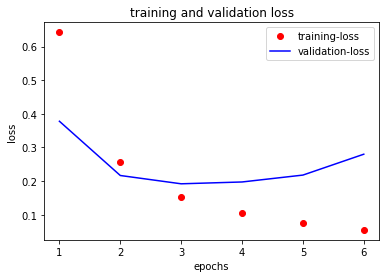

In [72]:
plot_losses(adhoc_history, 'ro', 'b', show=True, save=False)

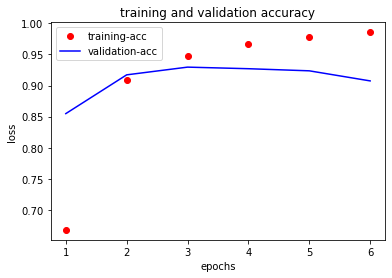

In [73]:
plot_accuracy(adhoc_history, 'ro', 'b', show=True, save=False)

In [47]:
dev_1 = SentimentModel.clone(sentiment, adhoc_model)

In [60]:
dev_1.predict_print("I wonder if this is a positive text?? hmm..")
dev_1.predict_print("I wonder if this is a negative text?? hmm..")

input: "I wonder if this is a positive text?? hmm.." < pos(😊) (71.9896)% >
input: "I wonder if this is a negative text?? hmm.." < neg(🤬) (0.3425)% >


In [64]:
test_simple(dev_1, 2)

* -- sentiment with punctuation -- *

input: "I hate this, but love it :)" < neg(🤬) (0.4056)% >
input: "I love this, but hate it :)" < neg(🤬) (0.7033)% >
input: "I hate this, but love it :(" < neg(🤬) (0.3612)% >
input: "I love this, but hate it :(" < neg(🤬) (0.5986)% >

* -- sentiment without punctuation -- *

input: "I hate this but love it :)" < neg(🤬) (0.4788)% >
input: "I love this but hate it :)" < neg(🤬) (1.9094)% >
input: "I hate this but love it :(" < neg(🤬) (0.422)% >
input: "I love this but hate it :(" < neg(🤬) (1.5635)% >


In [74]:
test_untrained(dev_1, untrainable, k=5)

💬 <old=0.0, new=3.5743, label=0>
 🤬 - i kinda prefer it to the s10,it

💬 <old=0.0, new=14.0078, label=0>
 😡 - Imagine you on your phone Your on a face time with your friends Then boom

💬 <old=0.0, new=21.1674, label=0>
 😠 - Rfhgrfhgfueh wrthgbc Cv.

💬 <old=0.0, new=11.0298, label=0>
 😡 - yeez a lot to discorver in front of me

💬 <old=0.0, new=2.6611, label=0>
 🤬 - He means the ignition button that you press to start the car



## Using Tensorflow

> Here's an example of how you can further experient with your dataset.

Here are all the objects you need to build other models.

```python
# get the embedding layer of shape Tuple[int, int, int]
vocab_size, embedding_dim, max_length = sentiment.embedding_layer

# make sure you pass the transformed training and testing(optional) sets
tf_history = tf_model.fit(x_train, y_train,
                          epochs=10,
                          verbose=1,
                          validation_data=(x_test, y_test))
```

In [75]:
import tensorflow as tf

vocab_size, embedding_dim, max_length = sentiment.embedding_layer
tf_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"), # lets try 24 hidden-units
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

tf_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 125, 300)          3944100   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                7224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,951,349
Trainable params: 3,951,349
Non-trainable params: 0
_________________________________________________________________


In [77]:
# note that I did't pass a batch size value here.
tf_history = tf_model.fit(x_train, y_train,
                          epochs=3,
                          verbose=1,
                          validation_data=(x_test, y_test))

Train on 37744 samples, validate on 9436 samples
Epoch 1/3
37744/37744 [==============================] - 63s 2ms/sample - loss: 0.1096 - acc: 0.9657 - val_loss: 0.2039 - val_acc: 0.9276
Epoch 2/3
37744/37744 [==============================] - 63s 2ms/sample - loss: 0.0957 - acc: 0.9707 - val_loss: 0.2072 - val_acc: 0.9308
Epoch 3/3
37744/37744 [==============================] - 63s 2ms/sample - loss: 0.0868 - acc: 0.9739 - val_loss: 0.2176 - val_acc: 0.9256


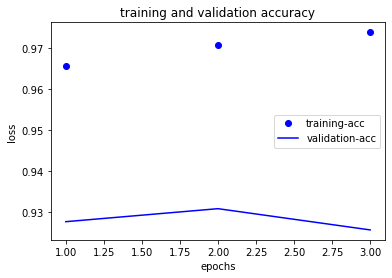

In [78]:
plot_accuracy(tf_history, 'bo', 'b')

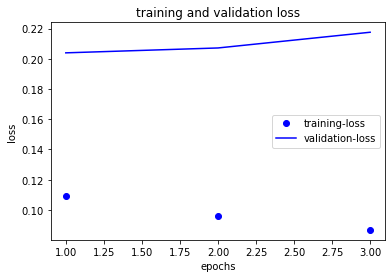

In [79]:
plot_losses(tf_history, 'bo', 'b')

In [80]:
dev_2 = SentimentModel.clone(sentiment, tf_model)
dev_2

<SentimentModel(max_seqlen=125, vocab_size=(13147, 300))>

In [81]:
dev_2.predict_print("I wonder if this is a positive text?? hmm..")
dev_2.predict_print("I wonder if this is a negative text?? hmm..")

input: "I wonder if this is a positive text?? hmm.." < pos(😁) (83.7627)% >
input: "I wonder if this is a negative text?? hmm.." < neg(🤬) (1.0908)% >


In [82]:
test_simple(dev_2, 2)

* -- sentiment with punctuation -- *

input: "I hate this, but love it :)" < neg(🤬) (1.8232)% >
input: "I love this, but hate it :)" < neg(🤬) (1.8232)% >
input: "I hate this, but love it :(" < neg(🤬) (1.9715)% >
input: "I love this, but hate it :(" < neg(🤬) (1.9715)% >

* -- sentiment without punctuation -- *

input: "I hate this but love it :)" < neg(🤬) (1.7842)% >
input: "I love this but hate it :)" < neg(🤬) (1.7842)% >
input: "I hate this but love it :(" < neg(🤬) (1.9294)% >
input: "I love this but hate it :(" < neg(🤬) (1.9294)% >


In [84]:
test_untrained(dev_2, untrainable, k=10)

💬 <old=0.0, new=8.67, label=0>
 😡 - # this is made by chirag madaan # here

💬 <old=0.0, new=5.6369, label=0>
 🤬 - There are maaany cameras with 1 lens that beat smartphone cameras

💬 <old=0.0, new=17.2233, label=0>
 😠 - So I don't give a fuck free market bitch.

💬 <old=0.0, new=40.8094, label=0>
 😒 - I understand that designers don't want to have a big boxy screen dictate design choices

💬 <old=0.0, new=79.0469, label=1>
 😁 - One world ,One Dream!I am Chinese!

💬 <old=0.0, new=18.0185, label=0>
 😠 - the wife & I bought last year has an infotainment system in it.

💬 <old=0.0, new=4.4264, label=0>
 🤬 - Unless the phone it something while it was being delivered.

💬 <old=0.0, new=5.0198, label=0>
 🤬 - Dont know if they scare me or what

💬 <old=0.0, new=48.7313, label=0>
 😶 - "This is all rubbish anyway.

💬 <old=0.0, new=37.5904, label=0>
 😬 - Mate 30 pro enter the chat.

